In [172]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame 
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
#from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error

In [173]:
from google.colab import files
uploaded = files.upload()

Saving sample30.csv to sample30 (1).csv


In [174]:
import io
df = pd.read_csv(io.BytesIO(uploaded['sample30.csv']))

**DATA OVERVIEW**

In [175]:
#data overivew
print('rows: ', df.shape[0])
print('columns: ', df.shape[1])
print('\nfeatures: ', df.columns.to_list())
print('\nmissing vlues: ', df.isnull().values.sum())
print('\nUnique values: \n', df.nunique())

rows:  30000
columns:  15

features:  ['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date', 'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating', 'reviews_text', 'reviews_title', 'reviews_userCity', 'reviews_userProvince', 'reviews_username', 'user_sentiment']

missing vlues:  74980

Unique values: 
 id                        271
brand                     214
categories                270
manufacturer              227
name                      271
reviews_date             6857
reviews_didPurchase         2
reviews_doRecommend         2
reviews_rating              5
reviews_text            27282
reviews_title           18535
reviews_userCity          977
reviews_userProvince       42
reviews_username        24914
user_sentiment              2
dtype: int64


In [176]:
df=df[['id','categories','name','reviews_didPurchase','reviews_doRecommend','reviews_rating','reviews_text','reviews_title','reviews_username','user_sentiment']]

In [177]:
#see the data types of different columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   30000 non-null  object
 1   categories           30000 non-null  object
 2   name                 30000 non-null  object
 3   reviews_didPurchase  15932 non-null  object
 4   reviews_doRecommend  27430 non-null  object
 5   reviews_rating       30000 non-null  int64 
 6   reviews_text         30000 non-null  object
 7   reviews_title        29810 non-null  object
 8   reviews_username     29937 non-null  object
 9   user_sentiment       29999 non-null  object
dtypes: int64(1), object(9)
memory usage: 2.3+ MB


In [178]:
#see the sum of missing values in each columns
df.isnull().sum()

id                         0
categories                 0
name                       0
reviews_didPurchase    14068
reviews_doRecommend     2570
reviews_rating             0
reviews_text               0
reviews_title            190
reviews_username          63
user_sentiment             1
dtype: int64

**There are no missing review_text and reviews_rating.However few usernames are missing.Later on this might create problems in rating prediction.So its better to remove them.**



In [179]:
#drop the rows having null values for reviews_username
df = df.dropna(subset=['reviews_username'])

In [180]:
#check sum of missing values in each columns
df.isnull().sum()

id                         0
categories                 0
name                       0
reviews_didPurchase    14006
reviews_doRecommend     2541
reviews_rating             0
reviews_text               0
reviews_title            189
reviews_username           0
user_sentiment             1
dtype: int64

**Duplicate reviews**

In [ ]:
#there are many duplicate reveiws (exact same comments in reviews_text)
#but I am not going to clean the data yet,so i just use the data as it is, to go through the process
df['reviews_text'].value_counts()[1:50]

Great                                                                                                                                                                                                                                                                                                                                                                                                                                                                        16
good                                                                                                                                                                                                                                                                                                                                                                                                                                                                         13
Great product                                                           

**Rating Distribution**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


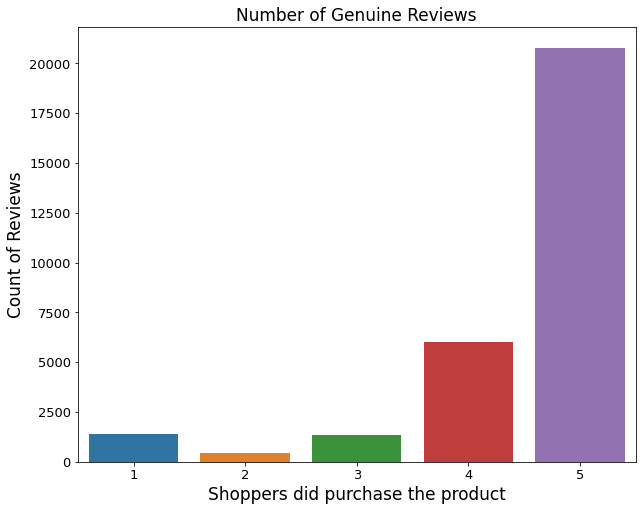

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 
plt.figure(figsize=(10,8))
ax = sns.countplot(df['reviews_rating'])
ax.set_xlabel(xlabel="Shoppers did purchase the product", fontsize=17)
ax.set_ylabel(ylabel='Count of Reviews', fontsize=17)
ax.axes.set_title('Number of Genuine Reviews', fontsize=17)
ax.tick_params(labelsize=13)

**Wordcloud for Reviews text given by user**

Number of words : 1027009


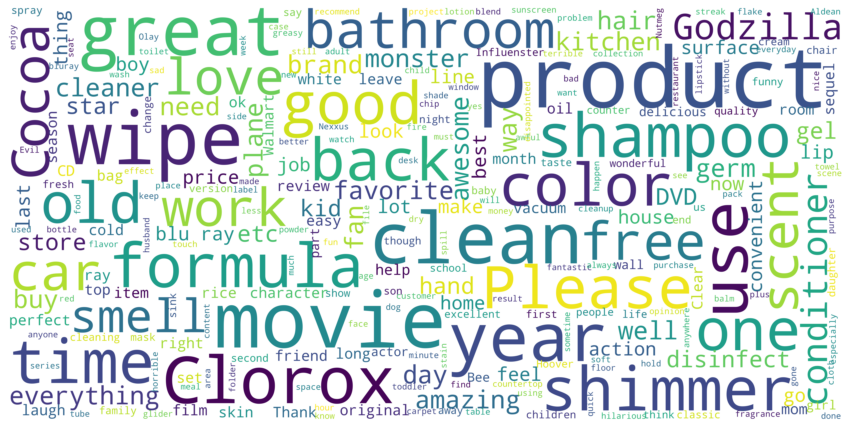

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

# try to tokenize to individual word (uni-gram) - reviews_text
split_title = []
listCounts = []
split_title = [x.split(" ") for x in df['reviews_text'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()

wordcloud = WordCloud(background_color='white', max_words=400, max_font_size=40, scale=30,
        random_state=1).generate((listCounts[listCounts > 2]).to_string())
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
print('Number of words :',len(big_list)) #reviews_text
plt.show()

**Wordcloud for Reviews title given by users**

In [ ]:
df['reviews_title'].value_counts()

Great Product                    384
Great movie                      361
Clorox Wipes                     278
Great                            221
Great product                    205
                                ... 
better then it got credit for      1
Exceptional product                1
cleans everything                  1
So glad I got this                 1
Works For Me                       1
Name: reviews_title, Length: 18490, dtype: int64

Number of titles : 95502


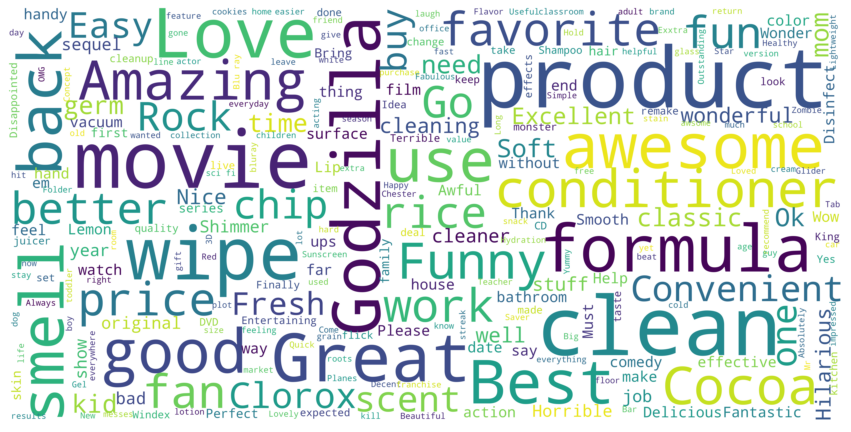

In [ ]:
# try to tokenize to individual word (uni-gram) - reviews_title
split_title = []
listCounts = []
split_title = [x.split(" ") for x in df['reviews_title'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()

wordcloud = WordCloud(background_color='white', max_words=400, max_font_size=40, scale=30,
        random_state=1).generate((listCounts[listCounts > 2]).to_string())
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
print('Number of titles :',len(big_list)) #reviews_titles
plt.show()

In [ ]:
#let's see what are the popular categories, looks quite messy
df['categories'].value_counts()

Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Cleaning & Janitorial Supplies,Cleaners & Disinfectants,Cleaning Wipes & Pads,Cleaning Solutions,Housewares,Target Restock,Food & Grocery,Paper Goods,Wipes,All Purpose Cleaners    8525
Movies, Music & Books,Movies,Action & Adventure,Movies & Music,Movies & TV Shows,Frys                                                                                                                                                                                                                                                                                                                                                                                                   3325
Household Chemicals,Household Cleaners,Bath & 

In [ ]:
#Let's see which are the popular products review
df['name'].value_counts()

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                         8525
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                   3325
Clorox Disinfecting Bathroom Cleaner                                              2039
L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz    1186
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)               1143
                                                                                  ... 
Sloan Royal Urinal Flush Valve, 1.0 Gpf, Royal 186-1                                 1
Blue Anchor Design Throw Pillow (18x18) - Rizzy Home                                 1
Wilton Black Dots Standard Baking Cups                                               1
Black Sister's Revenge (dvd)                                                         1
Wedding Wishes Wedding Guest Book                                                    1
Name: name, Length: 271, dtype: int64

**Genuine Reviews**

In [ ]:
#on the reviews.didpurchase column, replace 38,886 null filds with "Null"
df['reviews_didPurchase'].fillna('Null', inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


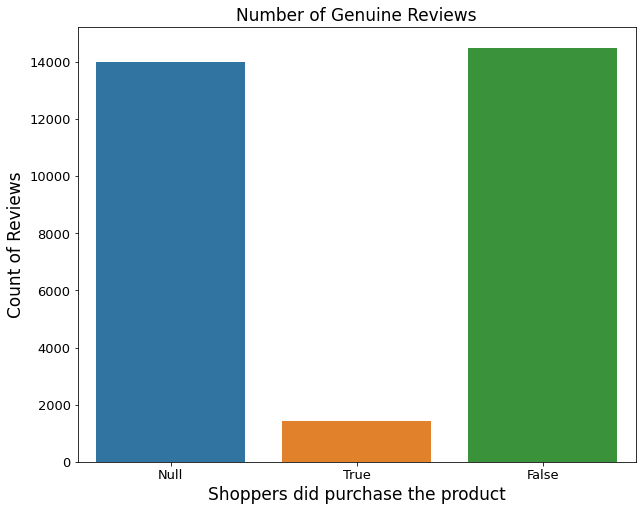

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 
plt.figure(figsize=(10,8))
ax = sns.countplot(df['reviews_didPurchase'])
ax.set_xlabel(xlabel="Shoppers did purchase the product", fontsize=17)
ax.set_ylabel(ylabel='Count of Reviews', fontsize=17)
ax.axes.set_title('Number of Genuine Reviews', fontsize=17)
ax.tick_params(labelsize=13)

In [ ]:
df['reviews_didPurchase'].value_counts()

False    14497
Null     14006
True      1434
Name: reviews_didPurchase, dtype: int64

In [ ]:
#shoppers who did purchase the product and provided the reveiw = 4.78%
1434/30000

0.0478

**Most Popular Product**

In [ ]:
df1 = df[df['reviews_didPurchase'] == True]
df1['name'].value_counts()

Hormel Chili, No Beans                                      91
Coty Airspun Face Powder, Translucent Extra Coverage        87
Chester's Cheese Flavored Puffcorn Snacks                   77
Tostitos Bite Size Tortilla Chips                           59
Lysol Concentrate Deodorizing Cleaner, Original Scent       55
                                                            ..
Clear Scalp & Hair Therapy Total Care Nourishing Shampoo     1
2x Ultra Era with Oxi Booster, 50fl oz                       1
Wagan Smartac 80watt Inverter With Usb                       1
Maybelline Clean Express! Makeup Removing Lotion             1
Bill Glor Gaither - Church In The Wildwood (cd)              1
Name: name, Length: 144, dtype: int64

***" Hormel Chili,No Beans " has been purchased most number of times ***

**Displaying top 10 Products purchased by Customer**

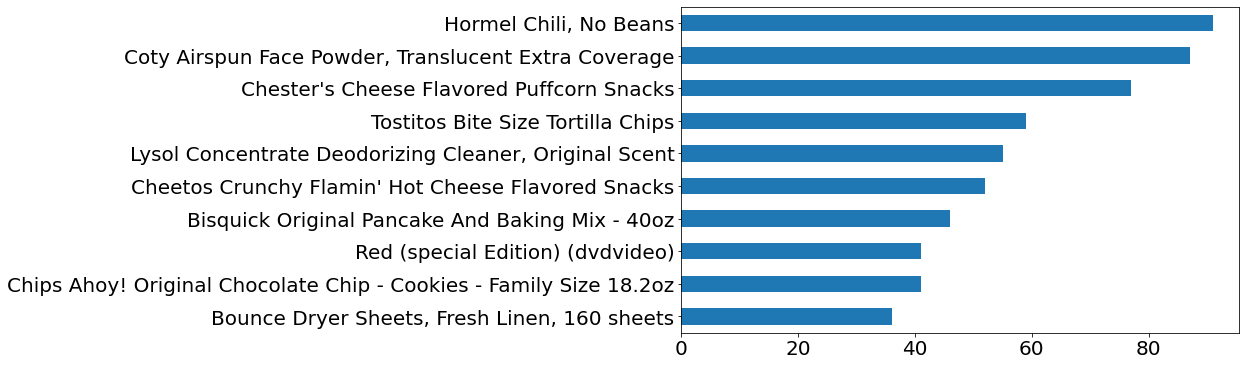

In [ ]:
df1['name'].value_counts()[0:10].plot(kind='barh', figsize=[10,6], fontsize=20).invert_yaxis()

**Prediction of Ratings**

In [181]:
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

all_text = df['reviews_text']
y = df['reviews_rating']

**Using n - gram tfidf Vectorizer**

In [182]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 3) )  # try 1,3
#     max_features=10000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(all_text)

In [183]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(all_text)

train_features = hstack([train_char_features, train_word_features])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:520: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


**Wordcloud for Reviews text given by user**

Number of words : 1027009


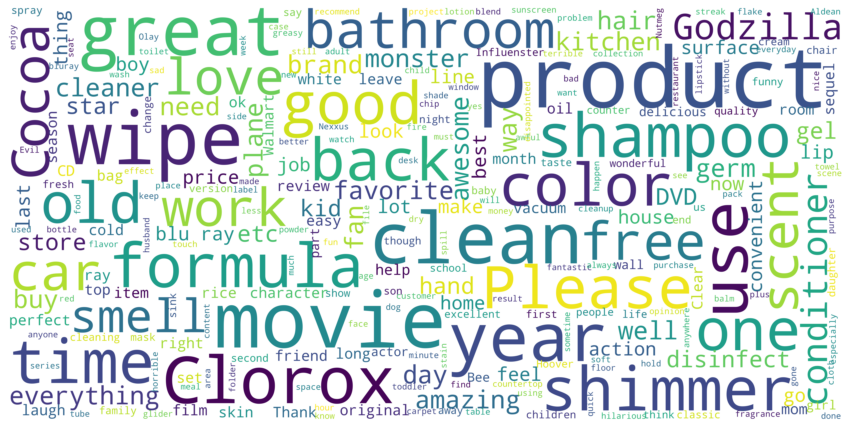

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

# try to tokenize to individual word (uni-gram) - reviews_text
split_title = []
listCounts = []
split_title = [x.split(" ") for x in df['reviews_text'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()

wordcloud = WordCloud(background_color='white', max_words=400, max_font_size=40, scale=30,
        random_state=1).generate((listCounts[listCounts > 2]).to_string())
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
print('Number of words :',len(big_list)) #reviews_text
plt.show()

**Wordcloud for Reviews title given by users**

In [ ]:
df['reviews_title'].value_counts()

Great Product                    384
Great movie                      361
Clorox Wipes                     278
Great                            221
Great product                    205
                                ... 
better then it got credit for      1
Exceptional product                1
cleans everything                  1
So glad I got this                 1
Works For Me                       1
Name: reviews_title, Length: 18490, dtype: int64

Number of titles : 95502


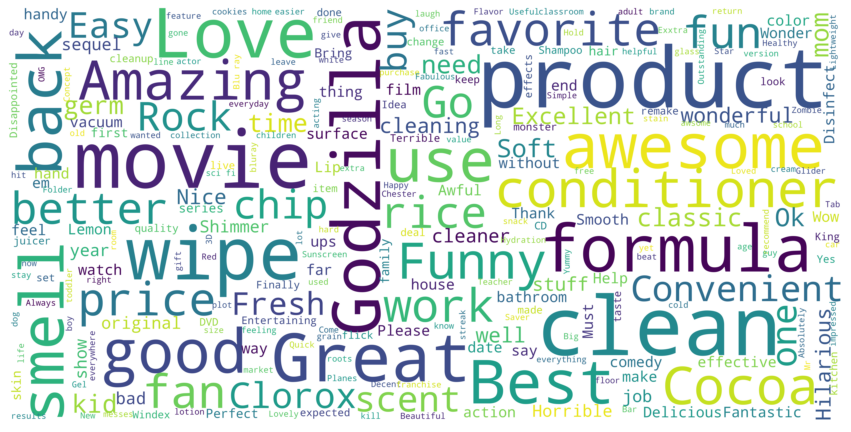

In [ ]:
# try to tokenize to individual word (uni-gram) - reviews_title
split_title = []
listCounts = []
split_title = [x.split(" ") for x in df['reviews_title'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()

wordcloud = WordCloud(background_color='white', max_words=400, max_font_size=40, scale=30,
        random_state=1).generate((listCounts[listCounts > 2]).to_string())
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
print('Number of titles :',len(big_list)) #reviews_titles
plt.show()

In [ ]:
import time 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
seed = 71

X_train, X_test, y_train, y_test = train_test_split(train_features, y, test_size=0.3, random_state=seed)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (20955, 569994)
y_train (20955,)
X_test (8982, 569994)
y_test (8982,)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


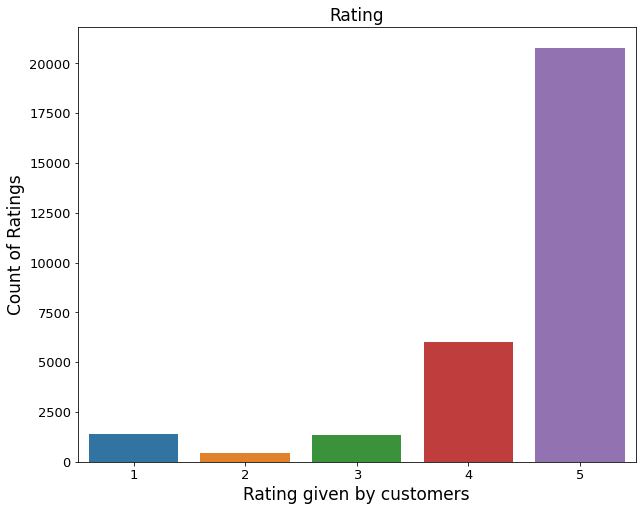

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 
plt.figure(figsize=(10,8))
ax = sns.countplot(df['reviews_rating'])
ax.set_xlabel(xlabel="Rating given by customers", fontsize=17)
ax.set_ylabel(ylabel='Count of Ratings', fontsize=17)
ax.axes.set_title('Rating', fontsize=17)
ax.tick_params(labelsize=13)

In [ ]:
df.reviews_rating

0        5
1        5
2        5
3        1
4        1
        ..
29995    5
29996    5
29997    5
29998    5
29999    5
Name: reviews_rating, Length: 29937, dtype: int64

**Model 2 : Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 71)

rdf = RandomForestClassifier(random_state = 0) 
scoring = {'Recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)
          }

params = {'max_depth': [6, 8, 10], 
              'min_samples_split': [5, 10, 15],
              'min_samples_leaf' : [4, 8, 12],
             }

grid_clf = GridSearchCV(estimator = rdf, param_grid = params, cv = cv, n_jobs=-1, verbose=4)
grid_clf.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 15.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=71, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                            

In [ ]:
print(grid_clf.best_estimator_)
print(grid_clf.best_params_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
time1 = time.time()
classifier = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False,
            random_state=71,
            verbose=0, warm_start=False)
classifier.fit(X_train, y_train)
preds1 = classifier.predict(X_test)

time_taken = time.time() -time1
print('Time taken: {:.2f} seconds'.format(time_taken))

Time taken: 14.34 seconds


In [ ]:
from sklearn.metrics import confusion_matrix
print("Random Forest Model accuracy", accuracy_score(preds1, y_test))
print(classification_report(preds1, y_test))
print(confusion_matrix(preds1, y_test))

Random Forest Model accuracy 0.7205522155421955
              precision    recall  f1-score   support

           1       0.37      0.92      0.53       167
           2       0.00      0.00      0.00         0
           3       0.00      1.00      0.00         1
           4       0.04      0.59      0.08       131
           5       1.00      0.72      0.84      8683

    accuracy                           0.72      8982
   macro avg       0.28      0.65      0.29      8982
weighted avg       0.97      0.72      0.82      8982

[[ 154   10    2    0    1]
 [   0    0    0    0    0]
 [   0    0    1    0    0]
 [   2    5   30   77   17]
 [ 256  102  384 1701 6240]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The accuracy of the model comes around 72%. Not a quite satisfying result it seems. Therefore we consider to divide ratings into two classes, so as to convert the problem to a binary classification problem. For this issue, we define rating 4 and 5 as "positive" rating (labelled as 1), and rating 1, 2 and 3 as "negative" rating (labelled as 0).

In [184]:
df.reviews_rating[df.reviews_rating == 1] = 1
df.reviews_rating[df.reviews_rating == 2] = 1
df.reviews_rating[df.reviews_rating == 3] = 1
df.reviews_rating[df.reviews_rating == 4] = 2
df.reviews_rating[df.reviews_rating == 5] = 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


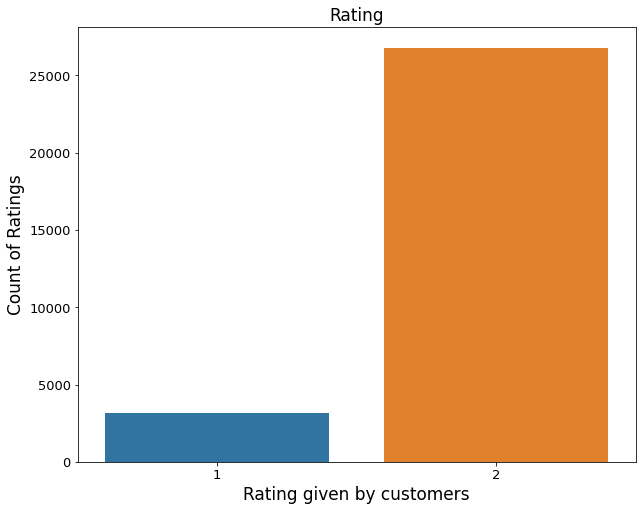

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 
plt.figure(figsize=(10,8))
ax = sns.countplot(df['reviews_rating'])
ax.set_xlabel(xlabel="Rating given by customers", fontsize=17)
ax.set_ylabel(ylabel='Count of Ratings', fontsize=17)
ax.axes.set_title('Rating', fontsize=17)
ax.tick_params(labelsize=13)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29937 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   29937 non-null  object
 1   categories           29937 non-null  object
 2   name                 29937 non-null  object
 3   reviews_didPurchase  29937 non-null  object
 4   reviews_doRecommend  27396 non-null  object
 5   reviews_rating       29937 non-null  int64 
 6   reviews_text         29937 non-null  object
 7   reviews_title        29748 non-null  object
 8   reviews_username     29937 non-null  object
 9   user_sentiment       29936 non-null  object
dtypes: int64(1), object(9)
memory usage: 3.8+ MB


In [ ]:
y1 = df['reviews_rating']

In [ ]:
df.reviews_rating.value_counts()

2    26802
1     3135
Name: reviews_rating, dtype: int64

In [ ]:
import time 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
seed = 71

X_train, X_test, y_train, y_test = train_test_split(train_features, y1, test_size=0.3, random_state=seed)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (20955, 569994)
y_train (20955,)
X_test (8982, 569994)
y_test (8982,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
time1 = time.time()
classifier = RandomForestClassifier(bootstrap=True, class_weight={1:4,2:0.47}, criterion='gini',
            n_estimators=100, n_jobs=-1,
            random_state=71)
classifier.fit(X_train, y_train)
preds1 = classifier.predict(X_test)

time_taken = time.time() -time1
print('Time taken: {:.2f} seconds'.format(time_taken))

Time taken: 80.14 seconds


In [ ]:
from sklearn.metrics import confusion_matrix
print("Random Forest Model accuracy", accuracy_score(preds1, y_test))
print(classification_report(preds1, y_test))
print(confusion_matrix(preds1, y_test))

Random Forest Model accuracy 0.9298597194388778
              precision    recall  f1-score   support

           1       0.34      0.99      0.50       322
           2       1.00      0.93      0.96      8660

    accuracy                           0.93      8982
   macro avg       0.67      0.96      0.73      8982
weighted avg       0.98      0.93      0.95      8982

[[ 319    3]
 [ 627 8033]]


As result suggest that by using class imbalance , the number of false positives have drastically reduced.This makes sure that wrong products will not be recommended to customers.This would improve delivery quality and recalls will be less.
Precision is also good. 
F1 Score for Positives is good.However there is scope of improvement with F1 Score for negatives. 

**Model2 : XGBoost**

To deal with class imbalance problem, we would use scale_pos_weight as hyperparameter.Scale_pos_weight=8036/946 i.e. total number of positives/total number of negatives.

In [ ]:
import xgboost as xgb
time1 = time.time()

xgb = xgb.XGBClassifier(scale_pos_weight = 8.53,n_jobs=1)
xgb.fit(X_train, y_train)
preds2 = xgb.predict(X_test)

time_taken = time.time() - time1
print('Time taken: {:.2f} seconds'.format(time_taken))

Time taken: 223.94 seconds


In [ ]:
print("XGBoost Model accuracy", accuracy_score(preds2, np.array(y_test)))

XGBoost Model accuracy 0.9180583389000223


In [ ]:
print("XGBoost Model accuracy", accuracy_score(preds2, y_test))
print(classification_report(preds2, y_test))
print(confusion_matrix(preds2, y_test))

XGBoost Model accuracy 0.9180583389000223
              precision    recall  f1-score   support

           1       0.23      0.97      0.37       222
           2       1.00      0.92      0.96      8760

    accuracy                           0.92      8982
   macro avg       0.61      0.94      0.66      8982
weighted avg       0.98      0.92      0.94      8982

[[ 216    6]
 [ 730 8030]]


**Model 3: Logistic Regression**

To deal with class imbalance problem, we would use scale_pos_weight as hyperparameter.Scale_pos_weight=8675/325 i.e. total number of positives/total number of negatives.



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
time1 = time.time()
logit = LogisticRegression(C=1, class_weight={1: 4.766, 1: 0.558})
logit.fit(X_train, y_train)
preds3 = logit.predict(X_test)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 13.87 seconds


In [ ]:
print("Logistic Regression accuracy", accuracy_score(preds3, y_test))
print(classification_report(preds3, y_test))
print(confusion_matrix(preds3, y_test))

Logistic Regression accuracy 0.9244043642841238
              precision    recall  f1-score   support

           1       0.29      0.98      0.45       279
           2       1.00      0.92      0.96      8703

    accuracy                           0.92      8982
   macro avg       0.64      0.95      0.70      8982
weighted avg       0.98      0.92      0.94      8982

[[ 273    6]
 [ 673 8030]]


Among three Models, **Logistic Regression gives best accuracy ( 92.44 % ) , Agreeable False Positives , Agreeable Precision and better computation efficiency** (only 18.55 sec) which is 12 times faster than XG Boost Classifier  and 19 times faster than Random Forest Classifier.

**SENTIMENT ANALYSIS**

**RECOMMENDATION SYSTEM**

In [185]:
df["id"] = df["id"].astype('category')
df["reviews_username"] = df["reviews_username"].astype('category')
df.dtypes

id                     category
categories               object
name                     object
reviews_didPurchase      object
reviews_doRecommend      object
reviews_rating            int64
reviews_text             object
reviews_title            object
reviews_username       category
user_sentiment           object
dtype: object

In [186]:
df["id_cat"] = df["id"].cat.codes
df["reviews_username_cat"] = df["reviews_username"].cat.codes

In [187]:
df.head(10)

,id,categories,name,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,id_cat,reviews_username_cat
0,AV13O1A8GV-KLJ3akUyj,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Pink Friday: Roman Reloaded Re-Up (w/dvd),NaN,NaN,2,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive,0,11440
1,AV14LG0R-jtxr-f38QfS,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg Organic Cinnamon Toast Rice Cakes,True,NaN,2,Good flavor. This review was collected as part...,Good,dorothy w,Positive,1,6974
2,AV14LG0R-jtxr-f38QfS,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg Organic Cinnamon Toast Rice Cakes,True,NaN,2,Good flavor.,Good,dorothy w,Positive,1,6974
3,AV16khLE-jtxr-f38VFn,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,False,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative,2,19327
4,AV16khLE-jtxr-f38VFn,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative,2,24205
5,AV16khLE-jtxr-f38VFn,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,False,False,1,My boyfriend and I bought this to spice things...,Not worth it,samantha,Negative,2,20202
6,AV16khLE-jtxr-f38VFn,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,False,False,1,Bought this earlier today and was excited to c...,Disappointing,raeanne,Negative,2,19123
7,AV16khLE-jtxr-f38VFn,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,False,False,1,I bought this product for my husband and I to ...,Not happy at all,kimmie,Negative,2,12585
8,AV16khLE-jtxr-f38VFn,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,False,False,1,My husband and I bought this for some extra fu...,Very disappointing,cassie,Negative,2,4249
9,AV16khLE-jtxr-f38VFn,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,False,False,1,Got as a surprise for my husband there is noth...,Don't buy,moore222,Positive,2,16650


In [ ]:
df = df.drop(columns=['id','reviews_username'],axis=1)

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29937 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   id                    29937 non-null  category
 1   categories            29937 non-null  object  
 2   name                  29937 non-null  object  
 3   reviews_didPurchase   15931 non-null  object  
 4   reviews_doRecommend   27396 non-null  object  
 5   reviews_rating        29937 non-null  int64   
 6   reviews_text          29937 non-null  object  
 7   reviews_title         29748 non-null  object  
 8   reviews_username      29937 non-null  category
 9   user_sentiment        29936 non-null  object  
 10  id_cat                29937 non-null  int16   
 11  reviews_username_cat  29937 non-null  int16   
dtypes: category(2), int16(2), int64(1), object(7)
memory usage: 3.1+ MB


**Dividing the dataset into train and test**

In [189]:
# Test and Train split of the dataset.
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.30, random_state=71)

In [190]:
print(train.shape)
print(test.shape)

(20955, 12)
(8982, 12)


In [191]:
# Pivot the train ratings' dataset into matrix format in which columns are item ID and the rows are user IDs.
df_pivot = pd.pivot_table(train,
    index='reviews_username_cat',
    columns='id_cat',
    values='reviews_rating',
    aggfunc='mean'
).fillna(0)

df_pivot.head(5)

id_cat,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,...,229,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,266,267,268,269,270
reviews_username_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [192]:
df_pivot.shape

(18254, 253)

**Creating dummy train & dummy test dataset**

In [193]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [194]:
# The items not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [195]:
# Convert the dummy train dataset into matrix format.
dummy_train_pivot = pd.pivot_table(dummy_train,
    index='reviews_username_cat',
    columns='id_cat',
    values='reviews_rating',
    aggfunc='mean'
).fillna(1)

In [ ]:
dummy_train.head()

In [197]:
dummy_train.shape

(20955, 12)

**User Similarity Matrix**

**Adjusted Cosine Similarity**

**Normalising the rating of the movie for each user around 0 mean**

In [198]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [199]:
df_subtracted.head()

id_cat,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,...,229,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,266,267,268,269,270
reviews_username_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,...,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905
1,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,0.992095,-0.007905,-0.007905,-0.007905,-0.007905,0.992095,-0.007905,-0.007905,...,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905
4,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,...,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905
5,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,...,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905
6,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-

In [200]:
df_subtracted.shape

(18254, 253)

In [201]:
from sklearn.metrics.pairwise import pairwise_distances
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[ 1.         -0.00562313 -0.00396825 ... -0.00396825 -0.00396825
  -0.00396825]
 [-0.00562313  1.         -0.00562313 ... -0.00562313  0.7057024
  -0.00562313]
 [-0.00396825 -0.00562313  1.         ... -0.00396825 -0.00396825
  -0.00396825]
 ...
 [-0.00396825 -0.00562313 -0.00396825 ...  1.         -0.00396825
   1.        ]
 [-0.00396825  0.7057024  -0.00396825 ... -0.00396825  1.
  -0.00396825]
 [-0.00396825 -0.00562313 -0.00396825 ...  1.         -0.00396825
   1.        ]]


In [202]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 0.       , ..., 0.       , 0.7057024,
        0.       ],
       [0.       , 0.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ],
       [0.       , 0.7057024, 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ]])

In [203]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.61313077, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.4585254 , 6.18934895, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.81515768, 8.66829128, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 3.32419324, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 4.32324052, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.32419324, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [204]:
user_predicted_ratings.shape

(18254, 253)

In [205]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train_pivot)
user_final_rating.head()

id_cat,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,...,229,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,266,267,268,269,270
reviews_username_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.613131,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,1.763240,0.0,0.0,0.0,0.0,0.613131,0.0,0.000000,...,1.411405,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.306565,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0
1,1.458525,6.189349,0.0,0.0,0.0,0.514114,0.000000,0.927634,0.0,0.0,0.0,0.0,0.00000,0.662551,0.662551,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.771562,0.0,0.0,0.0,0.0,0.61599,0.000000,4.700787,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.805090,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.239502,4.156901,0.0,0.0,0.0,0.385781,0.0,0.0,0.000000,2.329289,2.893923,0.932987,0.934946,0.0,0.0,1.078751,1.269111,0.0,0.0,0.000000,0.773014,0.0,1.38594,0.773014,0.0,0.0,0.0
4,1.815158,8.668291,0.0,0.0,0.0,0.000000,0.994030,0.994030,0.0,0.0,0.0,0.0,0.99403,0.581930,0.581930,0.887462,0.000000,0.0,1.150109,0.0,0.0,4.444284,0.0,0.0,0.0,0.0,0.00000,0.000000,11.207256,0.0,0.0,0.0,54.270123,0.0,0.0,0.0,0.0,32.267829,0.0,2.375300,...,1.150109,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.411405,0.0,0.0,0.000000,3.504918,0.0,0.0,0.0,1.963645,0.0,0.0,0.815959,1.538523,2.609841,1.988508,0.000000,0.0,0.0,2.405435,2.302872,0.0,0.0,0.544493,0.627233,0.0,0.00000,0.627233,0.0,0.0,0.0
5,0.000000,3.324193,0.0,0.0,0.0,0.000000,2.672801,0.887300,0.0,0.0,0.0,0.0,0.00000,0.581930,1.246979,0.000000,0.630698,0.0,0.000000,0.0,0.0,5.099715,0.0,0.0,0.0,0.0,0.00000,0.963895,1.888103,0.0,0.0,0.0,10.909295,0.0,0.0,0.0,0.0,10.297605,0.0,3.786705,...,0.000000,1.411405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.306565,3.592588,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.577378,0.000000,1.150109,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.98806,0.000000,0.0,0.0,0.0
6,0.000000,3.324193,0.0,0.0,0.0,0.000000,2.672801,0.887300,0.0,0.0,0.0,0.0,0.00000,0.581930,1.246979,0.000000,0.630698,0.0,0.000000,0.0,0.0,5.099715,0.0,0.0,0.0,0.0,0.00000,0.963895,1.888103,0.0,0.0,0.0,10.909295,0.0,0.0,0.0,0.0,10.297605,0.0,3.786705,...,0.000000,1.411405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.306565,3.592588,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.577378,0.000000,1.150109,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.98806,0.000000,0.0,0.0,0.0


**Finding the top 5 recommendation for the user**

In [206]:
# Take the user ID as input.
user_input = int(input("Enter your user name"))
print(user_input)

Enter your user name6
6


In [ ]:
user_final_rating.head(20)

In [208]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

id_cat
163    561.554735
187     27.575424
37      10.909295
103     10.486217
42      10.297605
196      8.924860
122      7.975026
171      6.323924
85       6.222274
68       5.199109
210      5.122955
24       5.099715
199      4.899263
91       4.523882
44       3.786705
244      3.592588
71       3.431727
119      3.369870
3        3.324193
92       3.315606
Name: 6, dtype: float64

In [209]:
d = pd.merge(d,df,left_on='id_cat',right_on='id_cat', how = 'left')
d.head()

,id_cat,6,id,categories,name,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_username_cat
0,163,561.554735,AVpfJP1C1cnluZ0-e3Xy,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,NaN,NaN,1,I'm disappointed Clorox Bathroom Spray doesn't...,Clorox Bathroom Spray,wkbu,Negative,24495
1,163,561.554735,AVpfJP1C1cnluZ0-e3Xy,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,False,True,1,I love that these are so convenient and smell ...,Great Product,jenni,Positive,10604
2,163,561.554735,AVpfJP1C1cnluZ0-e3Xy,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,False,NaN,1,I would have given this product a 5 star revie...,Hate the new scent,amcomber,Positive,932
3,163,561.554735,AVpfJP1C1cnluZ0-e3Xy,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,False,True,1,I was expecting these wipes to have a strong c...,Excellent Product,cass,Positive,4241
4,163,561.554735,AVpfJP1C1cnluZ0-e3Xy,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,False,False,1,I have used Clorox Wipes for years... Cannot l...,Who Changed the Scent,renee65,Positive,19442


**Evaluation - User User** 

In [211]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username_cat.isin(train.reviews_username_cat)]
common.shape

(1989, 12)

In [212]:
common.head()

,id,categories,name,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,id_cat,reviews_username_cat
17050,AVpf9pzn1cnluZ0-uNTM,"Food,Packaged Foods,Packaged Grains,Rice,Brown...","Lundberg Wehani Rice, 25lb",NaN,NaN,2,"this is excellent tasting and easy to prepare,...",Delicious,bykindle customer,Positive,113,3668
8544,AVpf3VOfilAPnD_xjpun,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox Disinfecting Wipes Value Pack Scented 1...,NaN,True,2,"I love Clorox Wipes Lemon, no matter what kind...",Clorox Disinfecting Wipes Lemon,jldh,Positive,93,11082
21959,AVpfN6Z71cnluZ0-gZmO,"Personal Care,Bath, Shower & Soap,Bar Soap,Bat...","Caress Moisturizing Body Bar Natural Silk, 4.75oz",True,True,2,I've tried a lot of different kinds of soap an...,Soap,debc,Negative,173,6347
29120,AVpfW8y_LJeJML437ySW,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'or233al Paris Elvive Extraordinary Clay Reba...,False,True,2,"i received this from influenster for review, t...",my new favorite conditioner,coronanatalie,Positive,210,5440
19234,AVpfJP1C1cnluZ0-e3Xy,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,False,True,2,Love the product. It smells fresh. This produc...,Great product,christine,Positive,163,4826


In [213]:

# convert into the user-movie matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username_cat', columns='id_cat', values='reviews_rating')

In [214]:
common_user_based_matrix.shape

(1686, 125)

In [215]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [216]:
df_subtracted.head(1)

id_cat,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,...,229,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,266,267,268,269,270
reviews_username_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,...,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905,-0.007905


In [217]:
user_correlation_df['reviews_username_cat'] = df_subtracted.index
user_correlation_df.set_index('reviews_username_cat',inplace=True)
user_correlation_df.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,18214,18215,18216,18217,18218,18219,18220,18221,18222,18223,18224,18225,18226,18227,18228,18229,18230,18231,18232,18233,18234,18235,18236,18237,18238,18239,18240,18241,18242,18243,18244,18245,18246,18247,18248,18249,18250,18251,18252,18253
reviews_username_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.705702,0.0,0.0,0.0,0.346485,0.0,0.0,0.0,0.496016,0.0,0.0,0.705702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.705702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.705702,0.0,0.0,0.0,0.0,0.0,0.0,0.705702,0.0,0.0,0.0,0.0,0.0,0.705702,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.497015,0.0,0.0,0.0,0.705702,1.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.44437,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.705702,1.0,0.44437,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.497015,1.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,1.0,1.0,1.0,0.000000,1.0
6,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.497015,1.0,1.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,1.0,1.0,1.0,0.000000,1.0


In [218]:
user_correlation_df.shape

(18254, 18254)

In [219]:
list_name = common.reviews_username_cat.tolist()
user_correlation_df.columns = df_subtracted.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [220]:
user_correlation_df_1.shape

(1686, 18254)

In [221]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

user_correlation_df_3 = user_correlation_df_2.T

user_correlation_df_3.head()

,17,92,108,144,179,223,234,251,265,277,283,302,307,320,334,339,357,376,382,412,442,460,464,520,542,551,553,565,566,568,600,606,624,662,665,674,682,782,785,820,...,24194,24212,24250,24260,24278,24305,24308,24315,24321,24343,24366,24372,24391,24425,24437,24483,24517,24523,24565,24569,24570,24576,24609,24691,24703,24707,24724,24730,24731,24734,24752,24776,24799,24801,24811,24827,24836,24870,24871,24876
reviews_username_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.705702,1.0,0.0,0.0,0.0,0.705702,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.44365,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.705702,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.705702,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
92,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.44365,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
108,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.705702,1.0,0.0,0.0,0.0,0.705702,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.44365,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.705702,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.705702,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
144,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.432751,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.705702,1.0,0.0,0.0,0.0,0.705702,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.44365,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.705702,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.705702,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [222]:
user_correlation_df_2.shape

(1686, 1686)

In [223]:
user_correlation_df_3.shape

(1686, 1686)

In [224]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings


array([[0.        , 0.43275051, 6.63069808, ..., 2.        , 0.        ,
        0.        ],
       [0.        , 0.        , 3.20228735, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.43275051, 6.63069808, ..., 2.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.62212875, 1.49283708, ..., 0.40463878, 0.        ,
        0.        ],
       [0.        , 0.        , 3.20228735, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.43275051, 6.63069808, ..., 2.        , 0.        ,
        0.        ]])

In [225]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username_cat', columns='id_cat', values='reviews_rating').fillna(0)

In [226]:
dummy_test.shape

(1686, 125)

In [227]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [228]:
common_user_predicted_ratings.head(5)

id_cat,0,2,3,7,8,9,12,15,16,17,18,19,22,24,30,33,37,40,41,42,47,48,53,54,55,56,58,60,61,64,66,67,68,69,70,71,73,76,77,78,...,172,173,176,180,181,182,186,187,190,192,193,194,196,197,199,205,206,209,210,213,215,218,221,227,233,235,239,243,244,246,252,253,255,257,258,260,265,267,269,270
reviews_username_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.493335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Calculating the RMSE for only the movies rated by user. For RMSE, normalising the rating to (1,2) range.

In [229]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 2))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [230]:
common_ = common.pivot_table(index='reviews_username_cat', columns='id_cat', values='reviews_rating')

In [231]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [232]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.3432684829977437


**Item Based Similarity**

In [233]:
train_2, test_2 = train_test_split(df, test_size=0.30, random_state=71)

In [234]:
print(train_2.shape)
print(test_2.shape)

(20955, 12)
(8982, 12)


In [235]:
# Pivot the train ratings' dataset into matrix format in which columns are movies and the rows are user IDs.
df_pivot = pd.pivot_table(train_2,
    index='reviews_username_cat',
    columns='id_cat',
    values='reviews_rating',
).T.fillna(0)

df_pivot.head(5)

reviews_username_cat,0,1,4,5,6,8,9,10,11,12,14,15,16,17,18,20,21,24,25,27,29,30,31,33,34,36,37,38,39,40,41,42,44,45,46,47,52,54,55,56,...,24855,24856,24857,24858,24859,24861,24862,24863,24864,24867,24868,24870,24871,24872,24873,24874,24875,24876,24878,24880,24881,24882,24883,24884,24885,24889,24892,24893,24894,24895,24896,24899,24901,24903,24908,24909,24910,24911,24912,24913
id_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [236]:
df_pivot.shape

(253, 18254)

In [237]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [ ]:
df_subtracted.head(50)

In [239]:
df_subtracted.shape

(253, 18254)

In [240]:
from sklearn.metrics.pairwise import pairwise_distances
# Creating the User Similarity Matrix using pairwise_distance function.
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 1.00000000e+00 -3.23338631e-03 -2.19232158e-04 ... -2.19232158e-04
  -2.19232158e-04 -8.07698566e-04]
 [-3.23338631e-03  1.00000000e+00 -8.08014366e-04 ... -8.08014366e-04
  -8.08014366e-04 -2.97689924e-03]
 [-2.19232158e-04 -8.08014366e-04  1.00000000e+00 ... -5.47855147e-05
  -5.47855147e-05 -2.01841655e-04]
 ...
 [-2.19232158e-04 -8.08014366e-04 -5.47855147e-05 ...  1.00000000e+00
  -5.47855147e-05 -2.01841655e-04]
 [-2.19232158e-04 -8.08014366e-04 -5.47855147e-05 ... -5.47855147e-05
   1.00000000e+00 -2.01841655e-04]
 [-8.07698566e-04 -2.97689924e-03 -2.01841655e-04 ... -2.01841655e-04
  -2.01841655e-04  1.00000000e+00]]


In [241]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

**Prediction - Item Item**

In [242]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.02601936, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01897181, 0.00183213, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0022902 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [243]:
item_predicted_ratings.shape

(18254, 253)

In [244]:
# Copy the train dataset into dummy_train
dummy_train = train_2.copy()

In [245]:
# The items not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [246]:
# Convert the dummy train dataset into matrix format.
dummy_train_pivot = pd.pivot_table(dummy_train,
    index='reviews_username_cat',
    columns='id_cat',
    values='reviews_rating',
    aggfunc='mean'
).fillna(1)

In [247]:
dummy_train.head()

,id,categories,name,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,id_cat,reviews_username_cat
12206,AVpf3VOfilAPnD_xjpun,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox Disinfecting Wipes Value Pack Scented 1...,False,True,0,these are outstanding to clean fast and effect...,wipes,deeds,Positive,93,6410
799,AV1YGDqsGV-KLJ3adc-O,"Household Essentials,Cleaning Supplies,Glass C...",Windex Original Glass Cleaner Refill 67.6oz (2...,False,True,0,It's handy and quickly clean up the dirty glas...,It's handy to keep it on hand to clean windshi...,pj,Positive,3,18668
784,AV1YGDqsGV-KLJ3adc-O,"Household Essentials,Cleaning Supplies,Glass C...",Windex Original Glass Cleaner Refill 67.6oz (2...,False,True,0,We prefer the original Windex with Ammonia D a...,This is a more economical version,cajunsouschef,Positive,3,3992
27720,AVpfRTh1ilAPnD_xYic2,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Planes: Fire Rescue (2 Discs) (includes Digita...,NaN,True,0,Better than first one. Dane cook still is an a...,Movie,mojogligrt54,Positive,196,16280
19155,AVpfJP1C1cnluZ0-e3Xy,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,False,True,0,LOVE these...they are my go to for cleaning up...,fav!!!,lpearson1,Positive,163,14245


In [248]:
dummy_train_pivot.shape

(18254, 253)

**Filtering the rating only for the items not rated by the user for recommendation**

In [249]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train_pivot)
item_final_rating.head()

id_cat,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,28,29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,...,229,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,266,267,268,269,270
reviews_username_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.026019,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.03256,0.0,0.0,0.0,0.0,0.011558,0.0,0.0,...,0.107635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.055776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.018972,0.001832,0.0,0.0,0.0,0.0,0.0,0.007338,0.0,0.0,0.0,0.0,0.0,0.016587,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014804,0.0,0.001914,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.006123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.014173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011976,0.008052,0.029807,0.005301,0.0,0.0,0.007921,0.021728,0.0,0.0,0.0,0.056499,0.0,0.048939,0.0,0.0,0.0,0.0
4,0.002290,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.007112,0.0,0.0,0.009286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042338,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.038744,0.000000,0.0,0.0,0.000941,0.011755,0.0,0.0,0.0,0.026124,0.0,0.000000,0.0,0.0,0.0,0.0
5,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016617,0.0,0.0,0.0,0.0
6,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016617,0.0,0.0,0.0,0.0


**Finding the top 20 recommendation for the user**

In [250]:
# Take the user ID as input
user_input = int(input("Enter your user name"))
print(user_input)

Enter your user name6
6


In [251]:
# Recommending the Top 20 products to the user.
d1 = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d1

id_cat
80     0.022358
69     0.022058
266    0.016617
95     0.008851
102    0.008356
195    0.001545
91     0.000000
87     0.000000
88     0.000000
89     0.000000
90     0.000000
93     0.000000
92     0.000000
85     0.000000
94     0.000000
96     0.000000
97     0.000000
86     0.000000
270    0.000000
84     0.000000
Name: 6, dtype: float64

In [252]:
d1 = pd.merge(d1,df,left_on='id_cat',right_on='id_cat',how = 'left')
d1.head()

,id_cat,6,id,categories,name,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,reviews_username_cat
0,80,0.022358,AVpf-bS61cnluZ0-uZcq,"Food,Packaged Foods,Snacks,Cereal Bars and Gra...",Nature's Path Chunky Chocolate Peanut Chewy Gr...,NaN,NaN,1,Nice snack bars.,NaN,fabio,Positive,7775
1,80,0.022358,AVpf-bS61cnluZ0-uZcq,"Food,Packaged Foods,Snacks,Cereal Bars and Gra...",Nature's Path Chunky Chocolate Peanut Chewy Gr...,NaN,NaN,2,These are so good! They taste like peanut choc...,NaN,christine,Positive,4826
2,69,0.022058,AVpe8q4T1cnluZ0-afct,"Food,Packaged Foods,Candy,Soft Candy,Candy & G...","Newman's Own Organics Licorice Twist, Black 5oz",NaN,NaN,1,Too soft. I had to leave it out to get it a bi...,NaN,karen,Negative,11919
3,69,0.022058,AVpe8q4T1cnluZ0-afct,"Food,Packaged Foods,Candy,Soft Candy,Candy & G...","Newman's Own Organics Licorice Twist, Black 5oz",NaN,NaN,1,unfortunately i didn't like these a lot...stil...,NaN,deb,Negative,6315
4,69,0.022058,AVpe8q4T1cnluZ0-afct,"Food,Packaged Foods,Candy,Soft Candy,Candy & G...","Newman's Own Organics Licorice Twist, Black 5oz",True,NaN,1,More like a sweet black jelly bean type flavor.,Not very much licorice flavor,robert b,Positive,19720


**Evaluation - Item Item**

In [253]:
# Find out the common users of test and train dataset.
common = test[test.id_cat.isin(train.id_cat)]
common.shape

(8962, 12)

In [ ]:
common.head()

In [255]:

# convert into the user-movie matrix.
common_item_based_matrix = common.pivot_table(index='reviews_username_cat', columns='id_cat', values='reviews_rating').T

In [256]:
common_item_based_matrix.shape

(195, 8330)

In [257]:
# Convert the user_correlation matrix into dataframe.
item_correlation_df = pd.DataFrame(item_correlation)

In [258]:
item_correlation_df['id_cat'] = df_subtracted.index
item_correlation_df.set_index('id_cat',inplace=True)
item_correlation_df.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
id_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.018972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.040773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011882,0.0,0.009719,0.0,0.0,0.0,0.0,0.0,0.0,0.022034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03077,0.0,0.0,0.0,0.0,0.001832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00522,0.002722,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.056332,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [259]:
item_correlation_df.shape

(253, 253)

In [260]:
list_name = common.id_cat.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [261]:
item_correlation_df_1.shape

(195, 253)

In [262]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

item_correlation_df_3.head()

,2,3,5,6,7,8,9,11,12,15,16,17,18,19,20,21,22,23,24,30,32,33,34,37,40,41,42,43,44,47,48,53,54,55,56,58,59,60,61,63,...,210,211,213,215,218,219,221,222,223,226,229,231,232,233,234,235,236,238,239,241,242,243,244,245,246,248,251,252,253,255,257,258,259,260,261,262,266,267,269,270
id_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.00000,0.0,0.0,0.018972,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.040773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011882,0.009719,0.0,0.0,0.0,0.0,0.0,0.0,0.022034,0.00000,0.000000,0.0,0.03077,0.0,0.0,0.001832,0.0,0.0,0.0,0.0,0.0,0.0,0.000558,0.0,0.01301,0.0,0.0,0.0,0.03574,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.001269,0.0,0.0,0.0,0.0,0.03561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00582,0.0,0.0,0.0,0.0,0.0,0.00522,0.002722,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.056332,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.04478,0.000328,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.02074,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [263]:
item_correlation_df_2.shape

(195, 195)

In [264]:
item_correlation_df_3.shape

(195, 195)

In [265]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings


array([[0.0011451, 0.0022902, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [266]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username_cat', columns='id_cat', values='reviews_rating').T.fillna(0)

In [267]:
dummy_test.shape

(195, 8330)

In [268]:
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [ ]:
common_item_predicted_ratings.head(50)

In [270]:
common_ = common.pivot_table(index='reviews_username_cat', columns='id_cat', values='reviews_rating').T

Calculating the RMSE for only the items rated by user. For RMSE, normalising the rating to (1,2) range.

In [275]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 2))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(1, 2))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [276]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [277]:
print(total_non_nan)

8710


In [278]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

0.9263147809759994


**DEPLOYMENT**

**1. Save the model**

In [ ]:
# Save the Model
from sklearn.externals import joblib
# Save the model as pickle in a file
joblib.dump(logit,)